In [30]:
using CSV, DataFrames, BioSequences, StatsPlots, Statistics, Distributions

In [31]:
standard_combos = CSV.File("SS_motifs.tsv"; delim = "\t") |> DataFrame
standard_combos.seq = LongAA.(standard_combos.seq)
standard_combos

Row,seq,combo
,LongAA,String3
1,TISWNICLKGLLNCGHSEMAQSFFLRVPEKD,ND
2,TISWTALVSGFARIGRKTDAVELFRRIPDKN,TN
3,IVSWNVMLNGYSKGKFVDLARDLFDKIPERD,ND
4,VISWNALLSAYVDRGMMDSASLVFDEMEERN,NN
5,VESWNFMISGFSKLGLIEEARRVFDESPVKD,ND
6,VISWTSMITAFMEFGMIELALDVFKKMPERN,TN
7,VVGWTCMINGFILCGDVKLARELFDLVVERD,TD
8,VVLWTTMISAYIEIGDMNNAQELFDKMPHKD,TD
9,VVTYNAMLSGYVQSGRISEACKFFEAMPVKN,NN


In [32]:
positive_pKs = Dict(AA_K => 10.0, AA_R => 12.0, AA_H => 5.98)
negative_pKs = Dict(AA_D => 4.05, AA_E => 4.45, AA_C => 9.0, AA_Y => 10.0)

function charge_at_pH(seq::LongAA, pH::Float64)::Float64
    # derivation:
    #   Henderson Hasselbalch equation: pH = pKa + log([A-]/[HA])
    #   Rearranging: [HA]/[A-] = 10 ** (pKa - pH)
    #   partial_charge =
    #       [A-]/[A]total = [A-]/([A-] + [HA]) = 1 / { ([A-] + [HA])/[A-] } =
    #       1 / (1 + [HA]/[A-]) = 1 / (1 + 10 ** (pKa - pH)) for acidic residues;
    #                             1 / (1 + 10 ** (pH - pKa)) for basic residues
    positive_charge = 0.0
    for aa in seq
        ~haskey(positive_pKs, aa) && continue
        pK = positive_pKs[aa]
        partial_charge = 1.0 / (10^(pH - pK) + 1.0)
        positive_charge += partial_charge
    end

    negative_charge = 0.0
    for aa in seq
        ~haskey(negative_pKs, aa) && continue
        pK = negative_pKs[aa]
        partial_charge = 1.0 / (10^(pK - pH) + 1.0)
        negative_charge += partial_charge
    end

    return positive_charge - negative_charge
end

function charge_at_pH(aa::AminoAcid, pH::Float64)::Float64
    # derivation:
    #   Henderson Hasselbalch equation: pH = pKa + log([A-]/[HA])
    #   Rearranging: [HA]/[A-] = 10 ** (pKa - pH)
    #   partial_charge =
    #       [A-]/[A]total = [A-]/([A-] + [HA]) = 1 / { ([A-] + [HA])/[A-] } =
    #       1 / (1 + [HA]/[A-]) = 1 / (1 + 10 ** (pKa - pH)) for acidic residues;
    #                             1 / (1 + 10 ** (pH - pKa)) for basic residues
    positive_charge = 0.0
    if haskey(positive_pKs, aa)
        pK = positive_pKs[aa]
        partial_charge = 1.0 / (10^(pH - pK) + 1.0)
        positive_charge += partial_charge
    end

    negative_charge = 0.0
    if haskey(negative_pKs, aa)
        pK = negative_pKs[aa]
        partial_charge = 1.0 / (10^(pK - pH) + 1.0)
        negative_charge += partial_charge
    end

    return positive_charge - negative_charge
end

charge_at_pH (generic function with 2 methods)

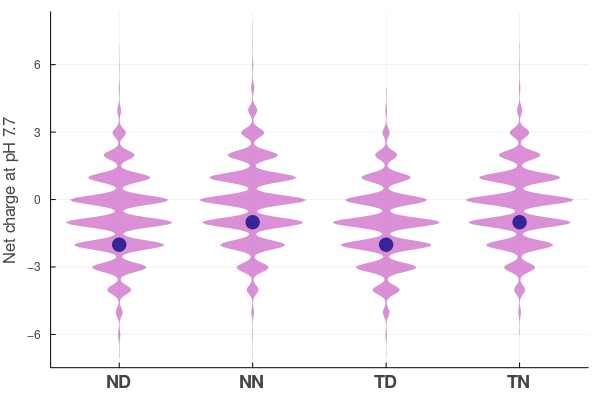

In [33]:
standard_combos.charge = charge_at_pH.(standard_combos.seq, 7.7)
@df standard_combos violin(:combo, :charge; legend = false, msw = 0, color = :orchid3, alpha = 0.75, yguide = "Net charge at pH 7.7", fontfamily = "Helvetica", xtickfontfamily = "Helvetica Bold", xtickfontsize = 12, lw = 0)

NN = LongAA("VVSWNAMISGYAQNGRIDEARELFDKMPERN")
ND = LongAA("VVSWNAMISGYAQNGRIDEARELFDKMPERD")
TN = LongAA("VVSWTAMISGYAQNGRIDEARELFDKMPERN")
TD = LongAA("VVSWTAMISGYAQNGRIDEARELFDKMPERD")

scatter!(["ND"], [charge_at_pH(ND, 7.7)]; color = :navy, alpha = 0.75, ms = 8, msw = 0)
scatter!(["NN"], [charge_at_pH(NN, 7.7)]; color = :navy, alpha = 0.75, ms = 8, msw = 0)
scatter!(["TD"], [charge_at_pH(TD, 7.7)]; color = :navy, alpha = 0.75, ms = 8, msw = 0)
scatter!(["TN"], [charge_at_pH(TN, 7.7)]; color = :navy, alpha = 0.75, ms = 8, msw = 0)

In [34]:
savefig("Fig 6B.svg")

"/Users/ian/github/GRASP/Fig 6B.svg"

In [35]:
aa_freq = zeros(Int, 2,20)
combo_map = Dict("ND" => 1, "NN" => 2, "TD" => 1, "TN" => 2)
aa_map = Dict(AA_A => 1, AA_C => 2, AA_D => 3, AA_E => 4, AA_F => 5, AA_G => 6, AA_H => 7, AA_I => 8, AA_K => 9, AA_L => 10, AA_M => 11, AA_N => 12, AA_P => 13, AA_Q => 14, AA_R => 15, AA_S => 16, AA_T => 17, AA_V => 18, AA_W => 19, AA_Y => 20)
for m in eachrow(standard_combos)
    i = combo_map[m.combo]
    j = aa_map[m.seq[29]]
    aa_freq[i, j] += 1
end
aa_freq

2×20 Matrix{Int64}:
 945  539  1657  8984  403  606  1038  …  2834  1136  993  681  2134  93  445
 572  443  1352  9486  260  431   674     2373   676  684  428  1300  70  279

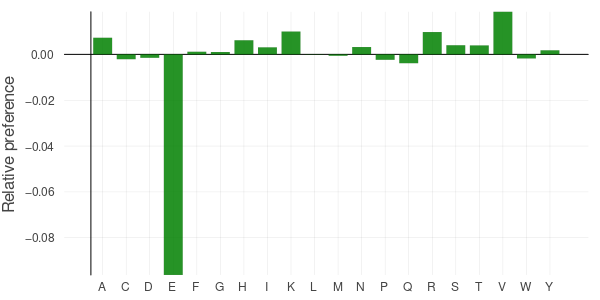

In [36]:
beta_diffs = Float64[]
prior_weight = 0.01
prior_alpha = prior_weight * sum(aa_freq[1, :])
prior_beta = prior_weight * sum(aa_freq[2, :])
for aa in 1:20
    α1 = aa_freq[1, aa]
    β1 = sum(aa_freq[1, :]) - α1
    D = Beta(α1 + prior_alpha, β1 + prior_beta)
    α2 = aa_freq[2, aa]
    β2 = sum(aa_freq[2, :]) - α2
    N = Beta(α2 + prior_alpha, β2 + prior_beta)
    push!(beta_diffs, mean(rand(D, 1000) .- rand(N, 1000)))
end
bar(sort(string.(keys(aa_map))), beta_diffs; lw = 0, color = :green, alpha = 0.85, xticks = :all, legend = false, size = (600, 300), fontfamily = "Helvetica", framestyle = :zerolines,
    yguide = "Relative preference")

In [37]:
savefig("Fig 6C.svg")

"/Users/ian/github/GRASP/Fig 6C.svg"